In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq pip gingado nbdev # install or upgrade gingado on colab

# Using gingado to understand economic growth
> An illustration with Barro and Lee (1994)

This notebook showcases one possible use of `gingado` by estimating economic growth across countries, using the dataset studied by Barro and Lee (1994, "Sources of economic growth", Carnegie-Rochester Conference Series on Public Policy, 40, p.1-46). You can run this notebook interactively, by clicking on the appropriate link above.

This dataset has been widely studied in economics. Belloni et al (2011, "Inference for high-dimensional sparse econometric models") and Giannone et al (2021, "Economic predictions with big data: the illusion of sparsity", Econometrica, 89, 5, p.2409-2437) are two studies of this dataset that are most related to machine learning.

This notebook will use `gingado` to compare different classes of models (and their combination in a single model), select the best performing alternative, and document it. Because the notebook is for pedagogical purposes only, please bear in mind some aspects of the machine learning workflow (such as carefully thinking about the cross-validation strategy) are glossed over in this notebook.

For a more thorough description of `gingado`, please refer to the package's [website](https://dkgaraujo.github.io/gingado) and to the academic [material](https://www.github.com/dkgaraujo/gingado_comms) about it.

## Setting the stage

We will import packages as the work progresses. This will help highlight the specific steps in the workflow that `gingado` can be helpful with.

In [ ]:
import pandas as pd
from scipy import io

The data is available in the [online annex](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17842) to Giannone et al (2021). In that paper, this dataset corresponds to what the authors call "macro2".

In [ ]:
growth_data = io.loadmat('data/GrowthData.mat')
colnames = [m[0].strip() for m in growth_data['Mnem'][0]]
df = pd.DataFrame(growth_data['data'], columns=colnames)

The dataset contains explanatory variables and the outcome variable, representing per-capita growth between 1960 and 1985, for 90 countries.

In [ ]:
df

,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,pm65,pf65,...,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1,Outcome
0,6.591674,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,0.37,0.21,...,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727,-0.024336
1,6.829794,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,1.00,0.65,...,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750,0.100473
2,8.895082,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,1.00,1.00,...,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040,0.067051
3,7.565275,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,1.00,1.00,...,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195,0.064089
4,7.162397,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,0.85,0.81,...,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283,0.027930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,8.991064,0.0000,0.371898,0.014586,0.255,0.336,0.170,0.98,0.99,1.00,...,2.226,2.494,1.971,27.5,15.9,0.4407,0.4257,2.529,-0.011883,0.031196
86,8.025189,0.0050,0.296437,0.013615,0.108,0.117,0.093,1.00,1.00,0.96,...,0.510,0.694,0.362,20.2,15.7,0.1669,0.2201,25.553,-0.039080,0.034096
87,9.030137,0.0000,0.265778,0.008629,0.288,0.337,0.237,1.00,1.00,0.95,...,2.727,2.664,2.788,20.4,9.4,0.3238,0.3134,4.152,0.005175,0.046900
88,8.865312,0.0000,0.282939,0.005048,0.188,0.236,0.139,1.00,1.00,1.00,...,1.888,1.920,1.860,20.0,16.0,0.1845,0.1940,0.452,-0.029551,0.039773


For the remainder of this notebook, the dataset will be divided into an `X` dataset of regressors and a `y` vector of outcomes.

In [ ]:
from sklearn.model_selection import train_test_split

y = df.pop('Outcome')
X = df

<AxesSubplot:ylabel='Frequency'>

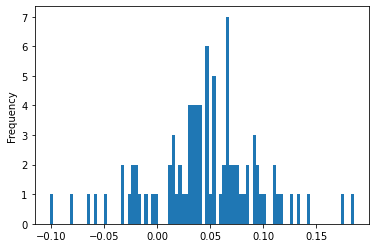

In [ ]:
y.plot.hist(bins=90)

In [ ]:
X

,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,pm65,pf65,...,seccf65,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1
0,6.591674,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,0.37,0.21,...,0.04,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727
1,6.829794,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,1.00,0.65,...,0.64,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750
2,8.895082,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,1.00,1.00,...,18.14,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040
3,7.565275,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,1.00,1.00,...,2.63,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195
4,7.162397,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,0.85,0.81,...,2.11,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,8.991064,0.0000,0.371898,0.014586,0.255,0.336,0.170,0.98,0.99,1.00,...,11.41,2.226,2.494,1.971,27.5,15.9,0.4407,0.4257,2.529,-0.011883
86,8.025189,0.0050,0.296437,0.013615,0.108,0.117,0.093,1.00,1.00,0.96,...,1.95,0.510,0.694,0.362,20.2,15.7,0.1669,0.2201,25.553,-0.039080
87,9.030137,0.0000,0.265778,0.008629,0.288,0.337,0.237,1.00,1.00,0.95,...,25.64,2.727,2.664,2.788,20.4,9.4,0.3238,0.3134,4.152,0.005175
88,8.865312,0.0000,0.282939,0.005048,0.188,0.236,0.139,1.00,1.00,1.00,...,10.76,1.888,1.920,1.860,20.0,16.0,0.1845,0.1940,0.452,-0.029551


# Establishing a benchmark model

Generally speaking, it is a good idea to establish a benchmark model at the first stages of development of the machine learning model. `gingado` offers a class of automatic benchmarks that can be used off-the-shelf depending on the task at hand: `RegressionBenchmark` and `ClassificationBenchmark`. It is also good to keep in mind that more advanced users can create their own benchmark on top of a base class provided by `gingado`: `ggdBenchmark`.

For this application, since we are interested in running a regression task, we will use `RegressionBenchmark`:

In [ ]:
from gingado.benchmark import RegressionBenchmark

What this object does is the following:
* it creates a random forest
* three different vesions of the random forest are trained on the user data
* the version that performs better is chosen as the benchmark
* right after it is trained, the benchmark is documented using `gingado`'s `ModelCard` documenter.

The user can easily change the parameters above. For example, instead of a random forest the user might prefer a neural network as the benchmark. Or, in lieu of the default parameters provided by `gingado`, users might have their own idea of what could be a reasonable parameter space to search.

Random forests are chosen as the go-to benchmark algorithm because of their reasonably good performance in a wide variety of settings, the fact that they don't require much data transformation (ie, normalising the data to have zero mean and one standard deviation), and by virtue of their relatively transparency about the importance of each regressor.

The first step is to initialise the benchmark object. At this time, we pass some arguments about how we want it to behave. In this case, we set the verbosity level to produce output related to each alternative considered.

In [ ]:
benchmark = RegressionBenchmark(verbose_grid=3)

The next step is to fit the `benchmark` object to the data. 

In [ ]:
#collapse_output
benchmark.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................n_estimators=50;, score=-0.360 total time=   0.1s
[CV 2/5] END ..................n_estimators=50;, score=-0.566 total time=   0.1s
[CV 3/5] END ...................n_estimators=50;, score=0.502 total time=   0.1s
[CV 4/5] END ..................n_estimators=50;, score=-0.486 total time=   0.1s
[CV 5/5] END ...................n_estimators=50;, score=0.225 total time=   0.1s
[CV 1/5] END .................n_estimators=100;, score=-0.448 total time=   0.2s
[CV 2/5] END .................n_estimators=100;, score=-0.371 total time=   0.2s
[CV 3/5] END ..................n_estimators=100;, score=0.498 total time=   0.2s
[CV 4/5] END .................n_estimators=100;, score=-0.452 total time=   0.2s
[CV 5/5] END ..................n_estimators=100;, score=0.263 total time=   0.2s
[CV 1/5] END .................n_estimators=250;, score=-0.402 total time=   0.4s
[CV 2/5] END .................n_estimators=250;, 

RegressionBenchmark(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=None,
            train_size=None),
                    verbose_grid=3)

As we can see above, with a few lines we have trained a random forest on the dataset. In this case, the benchmark was the better of three versions of the random forest: one with 50 estimators, another with 100 and the thid with 250 estimators. They were each trained using a 5-fold cross-validation. Let's see which one was the best performing in this case, and hence our benchmark model:

In [ ]:
pd.DataFrame(benchmark.benchmark.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.079545,0.004337,0.003843,0.000229,50,{'n_estimators': 50},-0.360396,-0.565551,0.502482,-0.486148,0.224607,-0.137001,0.423123,3
1,0.167421,0.012036,0.007171,0.000284,100,{'n_estimators': 100},-0.447668,-0.370655,0.497552,-0.451589,0.263048,-0.101863,0.401646,1
2,0.378822,0.024391,0.014742,0.001080,250,{'n_estimators': 250},-0.402150,-0.396590,0.422534,-0.554318,0.273290,-0.131447,0.398273,2


The values above are calculated with $R^2$, the default scoring function for a random forest from the `scikit-learn` package. Suppose that instead we would like a benchmark model that is optimised on the maximum error, ie a benchmark that minimises the worst deviation from prediction to ground truth for all the sample. These are the steps that we would take. Note that a more complete list of ready-made scoring parameters and how to create your own function can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#).

In [ ]:
#collapse_output
benchmark_lower_worsterror = RegressionBenchmark(scoring='max_error', verbose_grid=3)
benchmark_lower_worsterror.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................n_estimators=50;, score=-0.106 total time=   0.1s
[CV 2/5] END ..................n_estimators=50;, score=-0.160 total time=   0.1s
[CV 3/5] END ..................n_estimators=50;, score=-0.093 total time=   0.1s
[CV 4/5] END ..................n_estimators=50;, score=-0.155 total time=   0.1s
[CV 5/5] END ..................n_estimators=50;, score=-0.119 total time=   0.1s
[CV 1/5] END .................n_estimators=100;, score=-0.101 total time=   0.1s
[CV 2/5] END .................n_estimators=100;, score=-0.153 total time=   0.1s
[CV 3/5] END .................n_estimators=100;, score=-0.080 total time=   0.1s
[CV 4/5] END .................n_estimators=100;, score=-0.161 total time=   0.1s
[CV 5/5] END .................n_estimators=100;, score=-0.103 total time=   0.1s
[CV 1/5] END .................n_estimators=250;, score=-0.101 total time=   0.3s
[CV 2/5] END .................n_estimators=250;, 

RegressionBenchmark(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=None,
            train_size=None),
                    scoring='max_error', verbose_grid=3)

In [ ]:
pd.DataFrame(benchmark_lower_worsterror.benchmark.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.070497,0.002243,0.003129,0.000274,50,{'n_estimators': 50},-0.105720,-0.160192,-0.092559,-0.154933,-0.119283,-0.126537,0.026756,3
1,0.136517,0.002177,0.005583,0.000235,100,{'n_estimators': 100},-0.101473,-0.152549,-0.080398,-0.161343,-0.103194,-0.119791,0.031504,1
2,0.343452,0.004818,0.014053,0.000941,250,{'n_estimators': 250},-0.101465,-0.163865,-0.093425,-0.155408,-0.112444,-0.125321,0.028786,2


Now we even have two benchmark models 😎.

We could further tweek and adjust them, but one of the ideas behind having a benchmark is that it is simple and easy to set up. 

Let's now look at the predictions, comparing them to the original growth values.

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


<AxesSubplot:xlabel='y', ylabel='y_pred'>

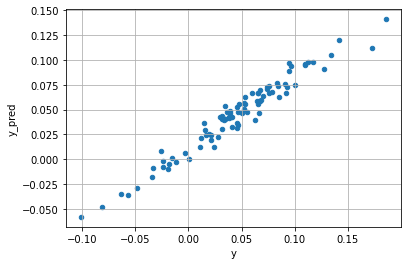

In [ ]:
y_pred = benchmark.predict(X)

pd.DataFrame({
    'y': y,
    'y_pred': y_pred
    }).plot.scatter(x='y', y='y_pred', grid=True)

And now a histogram of the benchmark's errors:

<AxesSubplot:ylabel='Frequency'>

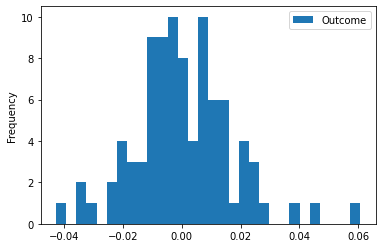

In [ ]:
pd.DataFrame(y - y_pred).plot.hist(bins=30)

Since the benchmark is a random forest model, we can see what are the most important regressors, measured as the average reduction in impurity across the trees in the random forest that actually use that particular regressor. They are scaled so that the sum for all features is one. Higher importance amounts indicate that that particular regressor is a more important contributor to the final prediction.

<AxesSubplot:>

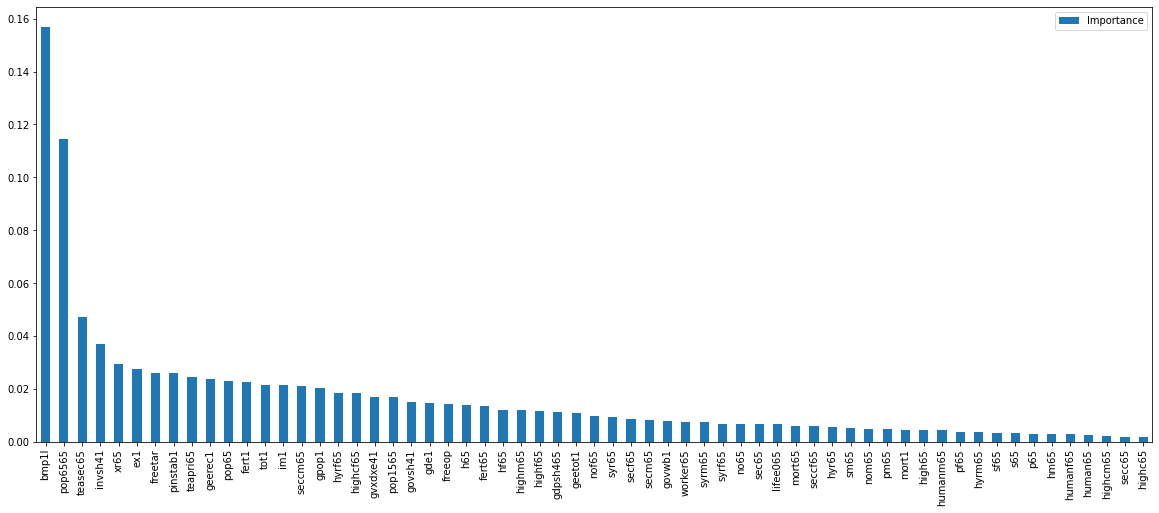

In [ ]:
regressor_importance = pd.DataFrame(benchmark.benchmark.best_estimator_.feature_importances_, index=X.columns, columns=["Importance"])

regressor_importance.sort_values(by="Importance", ascending=False).plot.bar(figsize=(20, 8))

From the graph above, we can see that the regressor `bmp1l` (black-market premium on foreign exchange) predominates. Interestingly, Belloni et al (2011) using squared-root lasso also find this regressor to be important.

## Model documentation

Importantly, the benchmark already has some baseline documentation set up. If the user wishes, they can use that as a basis to document their model. Note that the output is in a raw format that is suitable for machine reading and writing. Intermediary and advanced users may wish to use that format to construct personalised forms, documents, etc.

In [ ]:
#collapse_output
benchmark.model_documentation.show_json()

{'model_details': {'developer': 'douglasaraujo',
  'datetime': '2022-06-15 01:50:36 ',
  'version': 'Model version',
  'type': 'Model type',
  'info': {'_estimator_type': 'regressor',
   'best_estimator_': RandomForestRegressor(),
   'best_index_': 1,
   'best_params_': {'n_estimators': 100},
   'best_score_': -0.10186258819215784,
   'cv_results_': {'mean_fit_time': array([0.07954512, 0.16742129, 0.37882228]),
    'std_fit_time': array([0.00433701, 0.01203611, 0.02439085]),
    'mean_score_time': array([0.00384321, 0.00717115, 0.01474214]),
    'std_score_time': array([0.00022869, 0.00028425, 0.00107959]),
    'param_n_estimators': masked_array(data=[50, 100, 250],
                 mask=[False, False, False],
           fill_value='?',
                dtype=object),
    'params': [{'n_estimators': 50},
     {'n_estimators': 100},
     {'n_estimators': 250}],
    'split0_test_score': array([-0.36039585, -0.4476682 , -0.40214967]),
    'split1_test_score': array([-0.56555124, -0.3706552

Since there is some information in the model documentation that was automatically added, we might want to concentrate on the fields in the model card that are yet to be answered. Actually, this is the purpose of `gingado`'s automatic documentation: to afford users more time so they can invest, if they want, on model documentation.

In [ ]:
#collapse_output
benchmark.model_documentation.open_questions()

['model_details__version',
 'model_details__type',
 'model_details__paper',
 'model_details__citation',
 'model_details__license',
 'model_details__contact',
 'intended_use__primary_uses',
 'intended_use__primary_users',
 'intended_use__out_of_scope',
 'factors__relevant',
 'factors__evaluation',
 'metrics__performance_measures',
 'metrics__thresholds',
 'metrics__variation_approaches',
 'evaluation_data__datasets',
 'evaluation_data__motivation',
 'evaluation_data__preprocessing',
 'training_data__training_data',
 'quant_analyses__unitary',
 'quant_analyses__intersectional',
 'ethical_considerations__sensitive_data',
 'ethical_considerations__human_life',
 'ethical_considerations__mitigations',
 'ethical_considerations__risks_and_harms',
 'ethical_considerations__use_cases',
 'ethical_considerations__additional_information',
 'caveats_recommendations__caveats',
 'caveats_recommendations__recommendations']

Let's fill some information:

In [ ]:
benchmark.model_documentation.fill_info({
    'intended_use': {
        'primary_uses': 'This model is trained for pedagogical uses only.',
        'primary_users': 'Everyone is welcome to follow the description showing the development of this benchmark.'
    }
})

Note the format, based on a Python dictionary. In particular, the `open_questions` method results include keys divided by double underscores. As seen above, these should be interpreted as different levels of the documentation template, leading to a nested dictionary. 

Now when we confirm that the questions answered above are no longer "open questions":

In [ ]:
#collapse_output
benchmark.model_documentation.open_questions()

['model_details__version',
 'model_details__type',
 'model_details__paper',
 'model_details__citation',
 'model_details__license',
 'model_details__contact',
 'intended_use__out_of_scope',
 'factors__relevant',
 'factors__evaluation',
 'metrics__performance_measures',
 'metrics__thresholds',
 'metrics__variation_approaches',
 'evaluation_data__datasets',
 'evaluation_data__motivation',
 'evaluation_data__preprocessing',
 'training_data__training_data',
 'quant_analyses__unitary',
 'quant_analyses__intersectional',
 'ethical_considerations__sensitive_data',
 'ethical_considerations__human_life',
 'ethical_considerations__mitigations',
 'ethical_considerations__risks_and_harms',
 'ethical_considerations__use_cases',
 'ethical_considerations__additional_information',
 'caveats_recommendations__caveats',
 'caveats_recommendations__recommendations']

If we want, at any time we can save the documentation to a local JSON file, as well as read another document.

## Trying out model alternatives

The benchmark model may be enough for some analyses, or maybe the user is interested in using the benchmark to explore the data and have an understanding of the importance of each regressor, to concentrate their work on data that can be meaningful for their purposes. But oftentimes a user will want to seek a machine learning model that performs as well as possible.

For users that want to manually create other models, `gingado` allows the possibility of comparing them with the benchmark. If the user model is better, it becomes the new benchmark!

For the following analyses, we will use K-fold as cross-validation, with 5 splits of the sample.

### First candidate: a gradient boosting tree

In [ ]:
#collapse_output
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'learning_rate': [0.01, 0.1, 0.25],
    'max_depth': [3, 6, 9]
}

reg_gradbooster = GradientBoostingRegressor()

gradboosterg_grid = GridSearchCV(
    reg_gradbooster,
    param_grid,
    n_jobs=-1,
    verbose=3
).fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..learning_rate=0.01, max_depth=3;, score=-0.445 total time=   0.1s
[CV 3/5] END ...learning_rate=0.01, max_depth=3;, score=0.290 total time=   0.1s
[CV 2/5] END ..learning_rate=0.01, max_depth=3;, score=-0.510 total time=   0.1s
[CV 4/5] END ..learning_rate=0.01, max_depth=3;, score=-0.648 total time=   0.1s
[CV 5/5] END ...learning_rate=0.01, max_depth=3;, score=0.159 total time=   0.1s
[CV 1/5] END ..learning_rate=0.01, max_depth=6;, score=-0.818 total time=   0.2s
[CV 3/5] END ...learning_rate=0.01, max_depth=6;, score=0.464 total time=   0.2s
[CV 2/5] END ..learning_rate=0.01, max_depth=6;, score=-0.653 total time=   0.2s
[CV 4/5] END ..learning_rate=0.01, max_depth=6;, score=-0.723 total time=   0.2s
[CV 5/5] END ...learning_rate=0.01, max_depth=6;, score=0.087 total time=   0.2s
[CV 2/5] END ...learning_rate=0.1, max_depth=3;, score=-0.365 total time=   0.1s
[CV 1/5] END ..learning_rate=0.01, max_depth=9;, 

<AxesSubplot:xlabel='y', ylabel='y_pred'>

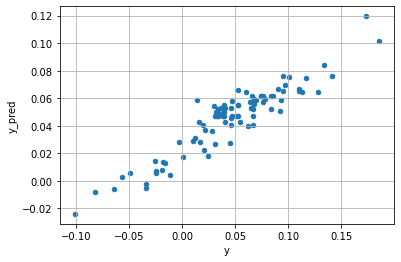

In [ ]:
y_pred = gradboosterg_grid.predict(X)
pd.DataFrame({
    'y': y,
    'y_pred': y_pred
    }).plot.scatter(x='y', y='y_pred', grid=True)

<AxesSubplot:ylabel='Frequency'>

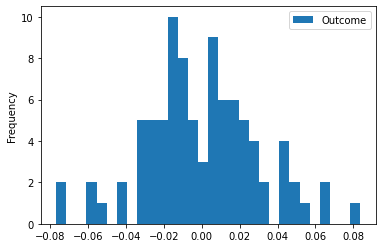

In [ ]:
pd.DataFrame(y - y_pred).plot.hist(bins=30)

### Second candidate: lasso

In [ ]:
#collapse_output
from sklearn.linear_model import Lasso

param_grid = {
    'alpha': [0.5, 1, 1.25],
}

reg_lasso = Lasso(fit_intercept=True)

lasso_grid = GridSearchCV(
    reg_lasso,
    param_grid,
    n_jobs=-1,
    verbose=3
).fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ........................alpha=0.5;, score=-0.074 total time=   0.0s
[CV 3/5] END ........................alpha=0.5;, score=-0.125 total time=   0.0s
[CV 2/5] END ........................alpha=0.5;, score=-0.552 total time=   0.0s
[CV 4/5] END ........................alpha=0.5;, score=-0.647 total time=   0.0s
[CV 1/5] END ..........................alpha=1;, score=-0.060 total time=   0.0s
[CV 5/5] END ........................alpha=0.5;, score=-0.129 total time=   0.0s
[CV 2/5] END ..........................alpha=1;, score=-0.659 total time=   0.0s
[CV 3/5] END ..........................alpha=1;, score=-0.152 total time=   0.0s
[CV 4/5] END ..........................alpha=1;, score=-0.676 total time=   0.0s
[CV 5/5] END ..........................alpha=1;, score=-0.096 total time=   0.0s
[CV 1/5] END .......................alpha=1.25;, score=-0.054 total time=   0.0s
[CV 2/5] END .......................alpha=1.25;, 

<AxesSubplot:xlabel='y', ylabel='y_pred'>

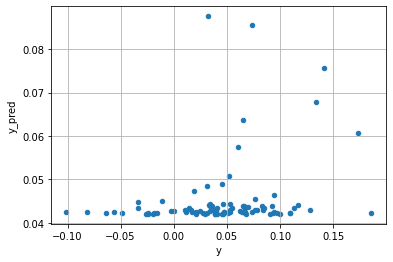

In [ ]:
y_pred = lasso_grid.predict(X)
pd.DataFrame({
    'y': y,
    'y_pred': y_pred
    }).plot.scatter(x='y', y='y_pred', grid=True)

<AxesSubplot:ylabel='Frequency'>

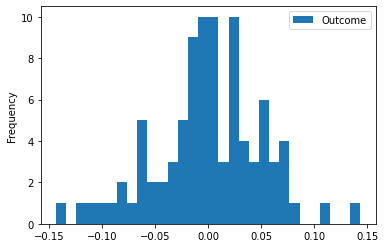

In [ ]:
pd.DataFrame(y - y_pred).plot.hist(bins=30)

## Comparing the models with the benchmark

`gingado` allows users to compare different candidate models with the existing benchmark in a very simple way: using the `compare` method.

In [ ]:
#collapse_output
candidates = [gradboosterg_grid, lasso_grid]
benchmark.compare(X, y, candidates)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................n_estimators=50;, score=-0.548 total time=   0.1s
[CV 2/5] END ...................n_estimators=50;, score=0.518 total time=   0.1s
[CV 3/5] END ..................n_estimators=50;, score=-1.042 total time=   0.1s
[CV 4/5] END ...................n_estimators=50;, score=0.218 total time=   0.1s
[CV 5/5] END ..................n_estimators=50;, score=-0.053 total time=   0.1s
[CV 1/5] END .................n_estimators=100;, score=-0.547 total time=   0.1s
[CV 2/5] END ..................n_estimators=100;, score=0.460 total time=   0.1s
[CV 3/5] END .................n_estimators=100;, score=-1.492 total time=   0.1s
[CV 4/5] END ..................n_estimators=100;, score=0.344 total time=   0.1s
[CV 5/5] END .................n_estimators=100;, score=-0.008 total time=   0.1s
[CV 1/5] END .................n_estimators=250;, score=-0.519 total ti

The output above clearly indicates that after evaluating the models - and their ensemble together with the existing benchmark - at least one of them was better than the current benchmark. Therefore, it will now be the new benchmark.

<AxesSubplot:xlabel='y', ylabel='y_pred'>

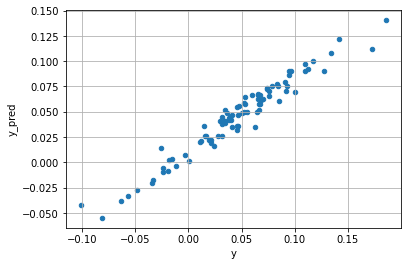

In [ ]:
y_pred = benchmark.predict(X)
pd.DataFrame({
    'y': y,
    'y_pred': y_pred
    }).plot.scatter(x='y', y='y_pred', grid=True)

<AxesSubplot:ylabel='Frequency'>

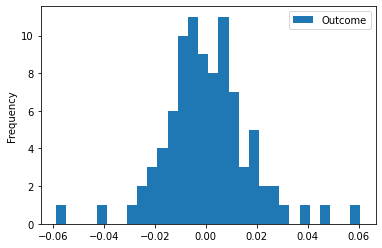

In [ ]:
pd.DataFrame(y - y_pred).plot.hist(bins=30)

## Model documentation

After this process, we can now see how the model documentation was updated automatically:

In [ ]:
#collapse_output
benchmark.model_documentation.show_json()

{'model_details': {'developer': 'douglasaraujo',
  'datetime': '2022-06-15 01:51:26 ',
  'version': 'Model version',
  'type': 'Model type',
  'info': {'_estimator_type': 'regressor',
   'best_estimator_': Pipeline(steps=[('candidate_estimator',
                    GridSearchCV(estimator=RandomForestRegressor(),
                                 param_grid={'n_estimators': [50, 100, 250]},
                                 verbose=3))]),
   'best_index_': 0,
   'best_params_': {'candidate_estimator': GridSearchCV(estimator=RandomForestRegressor(),
                 param_grid={'n_estimators': [50, 100, 250]}, verbose=3),
    'candidate_estimator__cv': None,
    'candidate_estimator__error_score': nan,
    'candidate_estimator__estimator': RandomForestRegressor(),
    'candidate_estimator__estimator__bootstrap': True,
    'candidate_estimator__estimator__ccp_alpha': 0.0,
    'candidate_estimator__estimator__criterion': 'squared_error',
    'candidate_estimator__estimator__max_depth': None,